In [27]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
import os
import pickle
import pymzn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import config
import data_loader
import statsmodel
from sklearn import linear_model, neural_network, svm
from sklearn.model_selection import cross_val_predict

# Evaluate Baseline Results

At first, we look at our baseline results without any optimization applied to the constraint models.

In [2]:
baseline = data_loader.get_baseline()

## Find failed runs

In [3]:
baseline[baseline.Failed == True].groupby(['Solver', 'Problem']).count()

,,Complete,DZN,Duration,Failed,HasBound,ObjBound,Objective
Solver,Problem,,,,,,,


In [4]:
# We create a DataFrame of all optimal values and all missing optimal values
baseline[(baseline.Objective.isnull())].groupby(['Problem']).count()
#pd.to_pickle(optima, os.path.join(config.OUTPUT_DIR, 'optima.p'))

,Complete,DZN,Duration,Failed,HasBound,ObjBound,Objective,Solver
Problem,,,,,,,,
2DBinPacking,724,724,724,724,724,0,0,724
jobshop,17,17,17,17,17,0,0,17
mrcpsp,1954,1954,1954,1954,1954,0,0,1954
open_stacks,42,42,42,42,42,0,0,42
prize-collecting,2,2,2,2,2,0,0,2
vrp,2,2,2,2,2,0,0,2


In [5]:
baseline[(baseline.Problem == 'vrp') & (baseline.DZN == 'P-n101-k4.vrp.dzn')]['Objective'].min()

4847.0

# Missing Optimal Objective Values

In [6]:
missing_optima = data_loader.missing_optima()
missing_optima.groupby(['Problem']).count()
#missing_optima

,DZN,Best
Problem,,
2DBinPacking,32,32
jobshop,17,17


In [7]:
missing_optima

,Problem,DZN,Best
0,2DBinPacking,Class2_60_6.dzn,3.0
1,2DBinPacking,Class2_100_10.dzn,5.0
2,2DBinPacking,Class2_80_6.dzn,4.0
3,2DBinPacking,Class2_80_8.dzn,4.0
4,2DBinPacking,Class7_100_2.dzn,28.0
5,2DBinPacking,Class7_80_10.dzn,25.0
6,2DBinPacking,Class7_100_6.dzn,30.0
7,2DBinPacking,Class1_100_2.dzn,33.0
8,2DBinPacking,Class3_100_1.dzn,20.0
9,2DBinPacking,Class3_100_3.dzn,20.0


In [8]:
baseline.groupby(['Problem']).agg({'Objective': [np.min, np.max, np.mean, np.std, lambda x: np.max(x)-np.min(x)]})

Objective                                            
                      amin     amax         mean          std <lambda>
Problem                                                               
2DBinPacking           1.0     78.0    13.012887    13.652265     77.0
jobshop               55.0  13316.0  2531.209756  2770.179855  13261.0
mrcpsp                 8.0    147.0    25.928758     8.880964    139.0
open_stacks            3.0     96.0    10.101852    13.878606     93.0
prize-collecting      20.0    115.0    58.487395    24.983831     95.0
vrp                  220.0  10732.0  2992.586364  2094.686327  10512.0

In [9]:
missing_optima[missing_optima.Problem == 'rcpsp'].sort_values(by=['DZN'])

,Problem,DZN,Best


for _, row in optima.iterrows():
    full_dir = os.path.join('minizinc-benchmarks', row['Problem'])
    dzn_path = [os.path.join(root, row['DZN']) for root, _, files in os.walk(full_dir) if row['DZN'] in files][0]
    opt_path = dzn_path + '.opt'
    open(opt_path, 'w').write('%d\n' % row['Objective'])
    

## Missing Results

In [10]:
#all_dzns = baseline[['Problem', 'DZN']].drop_duplicates()
#missing_results = []
#
#for solver in rel_solvers:
#    for _, dzn in all_dzns.iterrows():
#        if not ((baseline.DZN == dzn['DZN']) & (baseline.Solver == solver)).any():
#            missing_results.append((solver, dzn['Problem'], dzn['DZN']))

In [11]:
#pd.to_pickle(pd.DataFrame(missing_results, columns=['Solver', 'Problem', 'DZN']), os.path.join(config.OUTPUT_DIR, 'missing_results.p'))

## Show results

6


<IPython.core.display.Javascript object>


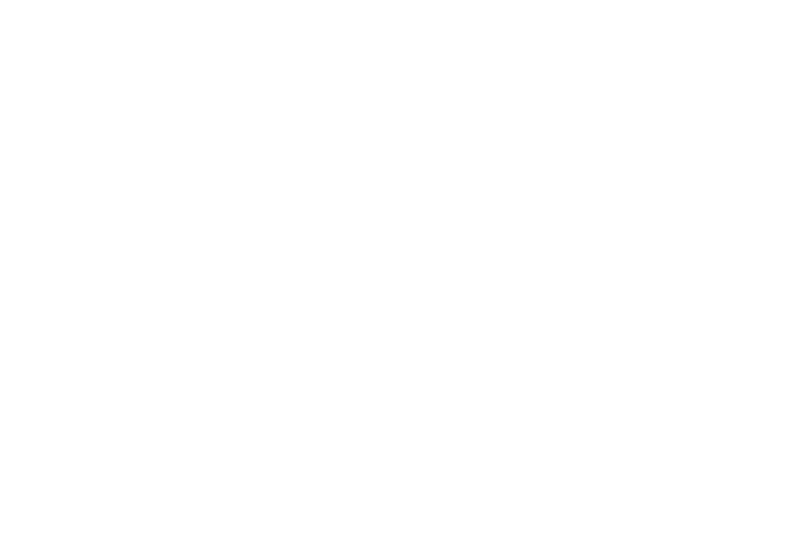

In [13]:
print(len(pd.unique(baseline.Problem)))
plt.figure()

for i, problem in enumerate(pd.unique(baseline.Problem.sort_values()), start=1):
    plt.subplot(330+i)
    baseline[baseline.Problem == problem]['Objective'].plot.hist(title=problem)

    plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


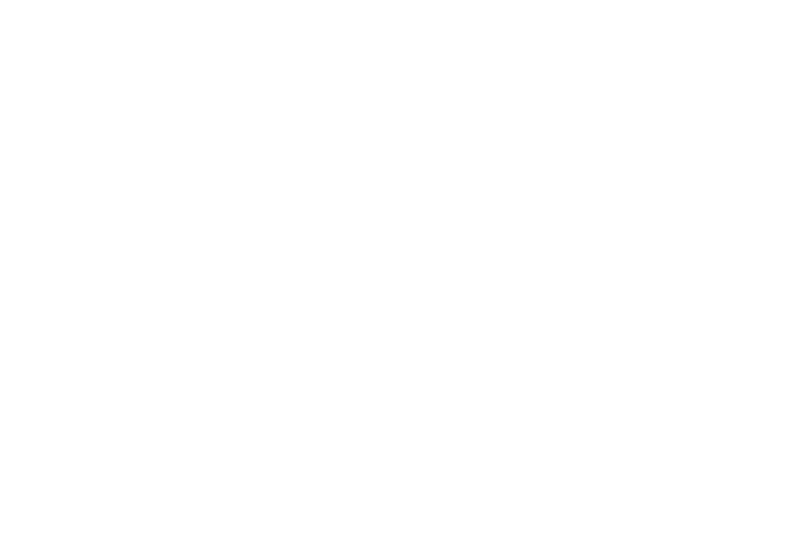

In [14]:
plt.figure()
ax = sns.barplot(x='Problem', y='Complete', hue='Solver', ci=None, data=baseline)
ax.set_title('Share of completed instances')

<IPython.core.display.Javascript object>


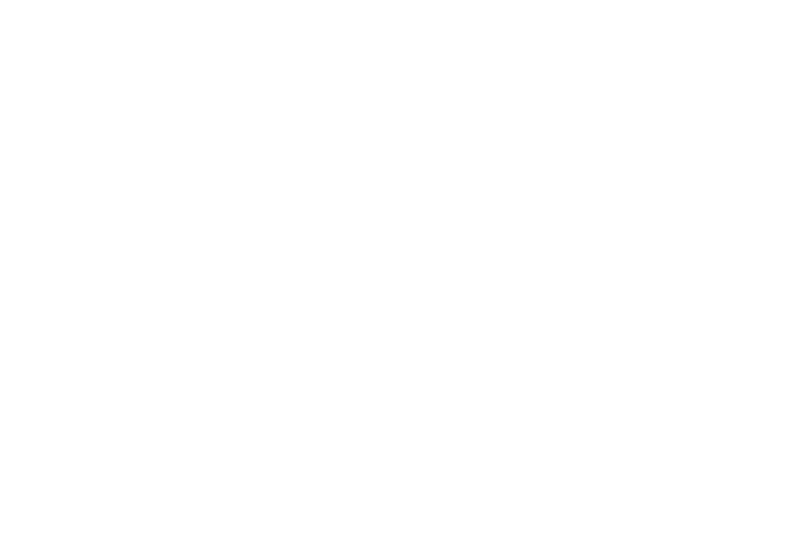

In [15]:
plt.figure()
ax = sns.barplot(x='Problem', y='Objective', hue='Solver', ci=None, data=baseline)
ax.set_title('Average objective value')

# MiniZinc Stats Model

In [16]:
#def nb_vars(problem):
problem = config.PROBLEMS[0]


In [23]:
feature_mat = statsmodel.feature_matrix(problem, True)

In [24]:
df = pd.DataFrame(feature_mat)
df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,32.0,5.437500,2.783181,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,2.401527,1.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,31.0
1,32.0,5.656250,3.274994,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.169950,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,33.0
2,32.0,5.281250,3.084582,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.203849,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,27.0
3,32.0,4.250000,2.633913,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.139021,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,25.0
4,32.0,6.000000,2.474874,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,2.939567,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,28.0
5,32.0,5.875000,3.018174,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.316395,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,34.0
6,32.0,4.812500,2.898680,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.459271,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,23.0
7,32.0,6.312500,2.799972,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.291168,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,40.0
8,32.0,5.812500,2.855231,1.0,10.0,16.0,32.0,4.0,16.0,4.0,...,3.147798,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,36.0
9,32.0,5.156250,2.463602,1.0,9.0,16.0,32.0,4.0,16.0,4.0,...,3.075774,0.0,10.0,4.0,1.500000,0.500000,1.0,2.0,13.0,25.0


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 12, 12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
5.24259883992


<IPython.core.display.Javascript object>


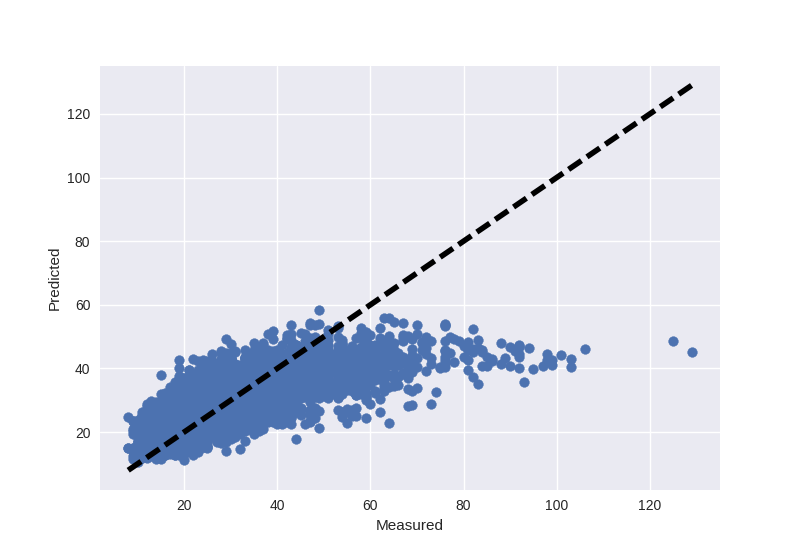

In [28]:
#lr = linear_model.SGDRegressor(loss='huber')
lr = neural_network.MLPRegressor((12,12,12))
#lr = linear_model.LassoCV()
#lr = svm.SVR(kernel='poly')
X = df.iloc[:,0:-1]
y = df.iloc[:, -1]

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:

predicted = cross_val_predict(lr, X, y, cv=10)

absloss = np.abs(predicted - y).sum() / len(predicted)
print(absloss)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Minizinc Benchmarks

Output a list of all minizinc benchmarks with more than 20 instances.

In [ ]:
lines = []

for problem_dir in os.listdir('minizinc-benchmarks'):
    full_dir = os.path.join('minizinc-benchmarks', problem_dir)
    
    if os.path.isfile(full_dir):
        continue
    
    problem_dzns = []  # List of all dzns, (filename, fullpath)

    for (sub_dir, _, files) in os.walk(full_dir):
        sub_dzns = [(f, os.path.join(sub_dir, f)) for f in files if f.endswith('.dzn')]
        problem_dzns.extend(sub_dzns)
    
    mzns = [f for f in os.listdir(full_dir) if f.endswith('.mzn')]
    
    if len(problem_dzns) >= 20:
        for m in mzns:
            psize = len(problem_dzns)
            train_set = int(psize * 0.8)
            test_set = psize - train_set
            lines.append((psize, "Problem('%s', '%s', 'minizinc-benchmarks', 'min'),  # %d (%d/%d)" % (problem_dir, m, psize, train_set, test_set)))

for _, l in sorted(lines, key=lambda x: -x[0]):
    print(l)